Imports.

In [1]:
import datetime
import time
import os
import sys
sys.path.insert(0, 'utils/')

import matplotlib.pyplot as plt

import numpy as np

from scipy.integrate import quad

import numba
from numba import njit

Testing TF, GPU drivers and ROCm support.

In [2]:
import tensorflow as tf
# because of tf version many warnings will occur
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import deepxde as dde

print('TF version: {}'.format(tf.__version__))
print('GPU support enabled: {}'.format(tf.test.is_built_with_gpu_support()))
print('ROCm support enabled: {}'.format(tf.test.is_built_with_rocm()))

TF version: 1.15.0
GPU support enabled: True
ROCm support enabled: False


Figures configuration for journal papers.

In [3]:
from plotting import latexconfig, figsize
latexconfig()

# 1D Bioheat transfer time-invariant equation

Time-variant 1D Pennes equation:

$$
\nabla(k \nabla T) + Q_b + Q_m + Q_{ext} = c_v \rho \frac{\partial T}{\partial t}
$$

where $Q_b = w_b \cdot T_a - w_b \cdot T$.

Time-invariant form:

$$
k \cdot \frac{d^2 T}{d x^2} - w_b \cdot T(x) + w_b \cdot T_a + Q_m + Q_{ext} = 0
$$

Boundary conditions:

**Dirichlet** $$
T_0(x) = T_c \hspace{10mm} x=L;
$$

**Robins** $$
-k \frac{dT_0(x)}{dx}=h_0[T_f - T_0(x)] \hspace{10mm} x=0.
$$

Calculations for no external source of heating, $Q_{ext} = 0$.

In [4]:
# consts 
c_b = 4200 
rho_b = 1e3 
om_b = 5e-4
c = 4200 
h_f = 100;
T_c = 37
L = 3e-2

# random variables
k = 0.5
w_b = c_b*rho_b*om_b
Q_m = 33800
h_0 = 10
T_f = 25
T_a = 37
rvs = [k, w_b, T_a, Q_m, h_0, T_f]
rvs = np.array(rvs).reshape(1, -1)

# solution domain
x = np.linspace(0, L, num=49)

Analytical solution.

In [5]:
def analyticSol(x):
    A = np.sqrt(w_b/k)
    lterm = (T_c - T_a - Q_m/w_b) * (A * np.cosh(A * x)  +\
                +  (h_0/k) * np.sinh(A * x)) / (A * np.cosh(A * L) + (h_0/k) * np.sinh(A * L))
    rterm = h_0/k * (T_f - T_a - Q_m/w_b) * np.sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * np.cosh(A * L) + (h_0/k) * np.sinh(A * L)) 

    return  T_a + Q_m/w_b + lterm + rterm

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


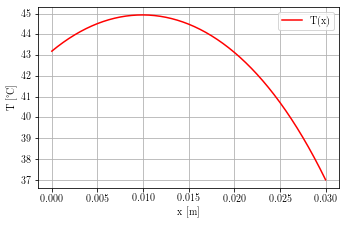

In [6]:
T_anal = analyticSol(x)

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.plot(x, T_anal, 'r-', label='T(x)')
ax.set_xlabel('x [m]')
ax.set_ylabel('T [°C]')
plt.grid()
plt.legend(loc='best')
plt.show()
fig.savefig('{}.pdf'.format('figs/analytical-solution'), bbox_inches='tight')

Monte Carlo simulation.

In [7]:
@njit
def monteCarloSim(x, rvs, coef_var=0.2, num_samples=1000, num_iters=1000):
    sims_global = np.empty(shape=(num_iters, num_samples, rvs.shape[1]))
    for i in range(num_iters):
        xi = np.random.rand(num_samples, len(rvs)) # random values
        sims = np.zeros(shape=xi.shape)            # empty simulations matrix
        
        rvs_min = rvs - coef_var*rvs              
        rvs_max = rvs + coef_var*rvs

        sims = rvs_min + (rvs_max - rvs_min) * xi
        sims_global[i, :, :] = sims
    return sims_global

@njit
def monteCarloT(x, K, w_b, T_a, Q_m, h_0, T_f):
    A = np.sqrt(w_b/K)
    lterm = (T_c - T_a - Q_m/w_b) * (A * np.cosh(A * x)  +\
                +  (h_0/K) * np.sinh(A * x)) / (A * np.cosh(A * L) + (h_0/K) * np.sinh(A * L))
    rterm = h_0/K * (T_f - T_a - Q_m/w_b) * np.sinh(A * (L * np.ones(shape=x.shape) - x)) / ( A * np.cosh(A * L) + (h_0/K) * np.sinh(A * L)) 

    return T_a + Q_m/w_b + lterm + rterm

@njit
def monteCarloResample(x, mc):
    num_iters, num_samples, n_rv = mc.shape
    
    T_mc = np.empty(shape=(num_iters, num_samples, x.shape[0]))
    
    for it in range(num_iters):
        for sample in range(num_samples):
            T_mc[it, sample, :] = monteCarloT(x, mc[it, sample, 0], mc[it, sample, 1], mc[it, sample, 2], mc[it, sample, 3], mc[it, sample, 4], mc[it, sample, 5])
    return T_mc

In [8]:
num_samples = 1000
num_iters = 100
coef_var = 0.2

start = time.time()
mc = monteCarloSim(x, rvs, coef_var, num_samples, num_iters)
T_mc = monteCarloResample(x, mc)
print('Simulation time: {}s'.format(time.time() - start))

Simulation time: 2.1494176387786865s


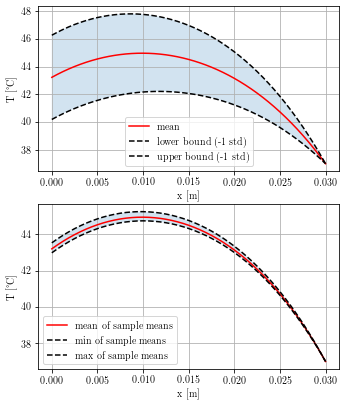

In [9]:
# single sample
_sample_exmp = 0
T_mc0 = T_mc[_sample_exmp]
T_mc0_mean = np.mean(T_mc0, axis=0)
T_mc0_std = np.std(T_mc0, axis=0)
T_mc0_lower_bound = T_mc0_mean - T_mc0_std
T_mc0_upper_bound = T_mc0_mean + T_mc0_std

fig = plt.figure(figsize=figsize(1, 2))
ax = fig.add_subplot(211)
ax.plot(x, T_mc0_mean, 'r-', label='mean')
ax.plot(x, T_mc0_lower_bound, 'k--', label='lower bound (-1 std)')
ax.plot(x, T_mc0_upper_bound, 'k--', label='upper bound (-1 std)')
ax.fill_between(x, T_mc0_lower_bound, T_mc0_upper_bound, alpha=0.2)
ax.set_xlabel('x [m]')
ax.set_ylabel('T [°C]')
plt.legend(loc='best')
# plt.title('Single MC sample')
plt.grid()

# full simulation
T_mc_mean = np.mean(T_mc, axis=1)
T_mean = np.mean(T_mc_mean, axis=0)
T_std = np.std(T_mc_mean, axis=0)
T_lower_bound = T_mc_mean[np.argmin(T_mc_mean[:, 0], axis=0)]
T_upper_bound = T_mc_mean[np.argmax(T_mc_mean[:, 0], axis=0)]

ax = fig.add_subplot(212)
ax.plot(x, T_mean, 'r-', label='mean of sample means')
ax.plot(x, T_lower_bound, 'k--', label='min of sample means')
ax.plot(x, T_upper_bound, 'k--', label='max of sample means')
ax.fill_between(x, T_lower_bound, T_upper_bound, alpha=0.2)
ax.set_xlabel('x [m]')
ax.set_ylabel('T [°C]')
plt.legend(loc='best')
# plt.title('MC num. of epochs: {}'.format(num_iters))
plt.grid()

fig.savefig('{}-{}epochs-{}samples.pdf'.format('figs/mc-simulation', num_iters, num_samples), bbox_inches='tight')
plt.show()

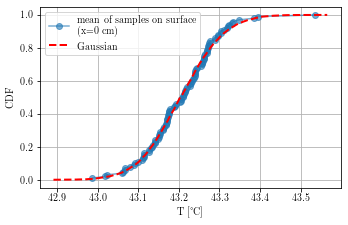

In [10]:
# distribution of sample means
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

# distribution
_exmp = 0
x_cdf, y_cdf = ecdf(T_mc_mean[:, _exmp])

# theretical gaussian distribution based on the MC simualted data
samples = np.random.normal(np.mean(T_mc_mean[:, _exmp]), np.std(T_mc_mean[:, _exmp]), 10000)
x_theor, y_theor = ecdf(samples)

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.plot(x_cdf, y_cdf, marker='o', alpha=0.6, label='mean of samples on surface \n(x=0 cm)')
ax.plot(x_theor, y_theor, 'r--', linewidth=2, label='Gaussian')
ax.set_xlabel('T [°C]')
ax.set_ylabel('CDF')
plt.grid()
plt.legend(loc='best')

fig.savefig('{}.pdf'.format('figs/mc-distribution'), bbox_inches='tight')
plt.show()

FEM.

In [11]:
def assemble_l(lhss, lhs_glob):
    if lhs_glob.shape[0]!=lhs_glob.shape[1]:
        raise Exception("Global matrix is not square matrix!") 
    else:
        for i, lhs in enumerate(lhss):
            lhs_glob[i:i+lhs.shape[0], i:i+lhs.shape[1]] += lhs
    return lhs_glob    

def assemble_r(rhss, rhs_glob):
    for i, rhs in enumerate(rhss):
        rhs_glob[i:i+rhs.shape[0], ] += rhs
    return rhs_glob

In [12]:
# domain
L = 3e-2
x = np.linspace(0, L, 100)

# fem
N = 10 # number of elements

# solution
lhs_glob = np.zeros((N+1, N+1))
T = np.zeros((N+1, 1))
rhs_glob = np.zeros((N+1, 1))

In [13]:
# base function combinations
n1 = lambda x, a, b:     (w_b*T_a + Q_m) * (b-x)/(b-a)
n2 = lambda x, a, b:     (w_b*T_a + Q_m) * (x-a)/(b-a)

nn11 = lambda x, a, b:    w_b * ((b-x)/(b-a))**2
nn12 = lambda x, a, b:    w_b * ((x-a)*(b-x))/((b-a)**2)
nn21 = lambda x, a, b:    w_b * ((x-a)*(b-x))/((b-a)**2)
nn22 = lambda x, a, b:    w_b * ((x-a)/(b-a))**2

nn_x11 = lambda x, a, b:  k/((b-a)**2)
nn_x12 = lambda x, a, b:  -k/((b-a)**2)
nn_x21 = lambda x, a, b:  -k/((b-a)**2)
nn_x22 = lambda x, a, b:  k/((b-a)**2)

In [14]:
a = 0
dx = L/N
b = dx
lhs = np.zeros((2, 2))
rhs = np.zeros((2, 1))
lhss = []
rhss = []
for i in range(N):
    print('{}. element: integration domain [{}, {}]'.format(i+1, a, b))
    lhs[0,0] = -(quad(nn11, a, b, args=(a, b))[0] + quad(nn_x11, a, b, args=(a, b))[0])
    lhs[0,1] = -(quad(nn12, a, b, args=(a, b))[0] + quad(nn_x12, a, b, args=(a, b))[0])
    lhs[1,0] = -(quad(nn21, a, b, args=(a, b))[0] + quad(nn_x21, a, b, args=(a, b))[0])
    lhs[1,1] = -(quad(nn22, a, b, args=(a, b))[0] + quad(nn_x22, a, b, args=(a, b))[0])
    lhss.append(lhs)
    
    rhs[0, 0] = -(quad(n1, a, b, args=(a, b))[0])
    rhs[1, 0] = -(quad(n2, a, b, args=(a, b))[0])
    rhss.append(rhs)
    
    a = a + dx
    b = b + dx

1. element: integration domain [0, 0.003]
2. element: integration domain [0.003, 0.006]
3. element: integration domain [0.006, 0.009000000000000001]
4. element: integration domain [0.009000000000000001, 0.012]
5. element: integration domain [0.012, 0.015]
6. element: integration domain [0.015, 0.018]
7. element: integration domain [0.018, 0.020999999999999998]
8. element: integration domain [0.020999999999999998, 0.023999999999999997]
9. element: integration domain [0.023999999999999997, 0.026999999999999996]
10. element: integration domain [0.026999999999999996, 0.029999999999999995]


In [15]:
# assemble in global matrices
lhs_glob = assemble_l(lhss, lhs_glob)
rhs_glob = assemble_r(rhss, rhs_glob)

In [16]:
# boundary conds
# DBC
T[-1, 0] = T_c                   
lhs_glob = lhs_glob[:-1, :-1]
rhs_glob = rhs_glob[:-1, ]

# RBC
lhs_glob[0, 0] -= h_0            
rhs_glob[0, 0] -= h_0 * T_f
rhs_glob[-1, 0] -= T_c * lhs_glob[-1, -2] 

In [17]:
# T = B \ A
T[:-1, ] = np.linalg.inv(lhs_glob) @ rhs_glob

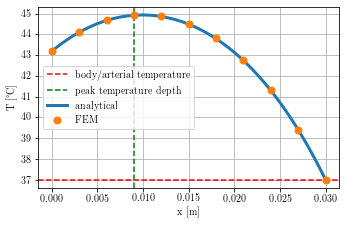

In [18]:
x_anal = np.linspace(0, L, num=T_anal.shape[0])
x = np.linspace(0, L, num=T.shape[0])

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.axhline(y=T_c, color='red', linestyle='--', label='body/arterial temperature')
ax.axvline(x=x[np.where(np.max(T)==T)[0]], color='green', linestyle='--', label='peak temperature depth')
ax.plot(x_anal, T_anal, linewidth=3, label='analytical')
ax.plot(x, T, linestyle='None', marker='o', markersize=7, label='FEM')
ax.set_xlabel('x [m]')
ax.set_ylabel('T [°C]')
plt.grid()
plt.legend(loc='best')
# plt.title('{} finite elements'.format(N))

fig.savefig('{}-{}felems.pdf'.format('figs/FEM', N), bbox_inches='tight')
plt.show()

Data-driven solution of time-independent PDE using Physics-informed Neural Network approach. Instead of dealing with it numerically, the solution is transformed into optimization problem:

$$
k \cdot \frac{d^2 T}{d x^2} - w_b \cdot T(x) + w_b \cdot T_a + Q_m  = 0
$$

$$ \Downarrow $$

$$
J(\theta) = [k \cdot \frac{d^2 \hat{T}}{d x^2} - w_b \cdot \hat T(x) + w_b \cdot T_a + Q_m]^2 + [\hat T(0) - T_0]^2 + [\hat T(L) - T_L]^2
$$

$$
\mbox{Optimization: } \fbox{ $\min_{\theta} J(\theta)$}
$$

where:
* $J(\theta)$ is the cost function;
* $\hat{T}(x)$ is the neural network's output for every input x and
* $T_0$ and $T_L$ are boundary conditions.


Neural network configuration:
* activation: tanh
* initializer: Glorot uniform
* architecture: input (1), 3 hidden (50), output (1)
* optimization: Adam
* metrics: l2 relative error


In [19]:
def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_xx = tf.gradients(dy_x, x)[0]
    return k*dy_xx - w_b*y + (w_b*T_a + Q_m)

def boundary_l(x, on_boundary):
    return on_boundary

def boundary_r(x, on_boundary):
    return on_boundary

In [20]:
geom = dde.geometry.Interval(0, L)
bc_l = dde.RobinBC(geom, lambda X, y: (h_0/k)*y - (h_0*T_f/k), boundary_l)
bc_r = dde.DirichletBC(geom, lambda x: 0*x + T_c, boundary_r)
data = dde.data.PDE(geom, 1, pde, [bc_l, bc_r], 16, 2, func=None, num_test=100)

layer_size = [1] + [40] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

t = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
new_model_path = 'model/{}'.format(t)
if not os.path.exists(new_model_path):
    os.makedirs(new_model_path)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000, uncertainty=True)

dde.postprocessing.save_loss_history(losshistory, 'model/{}/loss.dat'.format(t))
dde.postprocessing.save_best_state(train_state, 'model/{}/train.dat'.format(t), 'model/{}/test.dat'.format(t))

Building feed-forward neural network...
'build' took 0.057860 s

Compiling model...
'compile' took 0.854868 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.24e+10, 2.50e+05, 1.37e+03]    [1.24e+10, 0.00e+00, 0.00e+00]    [inf]         


/home/alk/anaconda3/lib/python3.7/site-packages/deepxde/metrics.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  return np.linalg.norm(y_true - y_pred) / np.linalg.norm(y_true)


1000      [5.66e+08, 1.12e+05, 2.27e+01]    [5.66e+08, 0.00e+00, 0.00e+00]    [inf]         
2000      [4.13e+06, 2.94e+05, 2.29e+02]    [4.13e+06, 0.00e+00, 0.00e+00]    [inf]         
3000      [8.36e+02, 3.15e+05, 2.59e+02]    [8.34e+02, 0.00e+00, 0.00e+00]    [inf]         
4000      [3.51e+01, 3.16e+05, 2.59e+02]    [3.46e+01, 0.00e+00, 0.00e+00]    [inf]         
5000      [3.25e+01, 3.16e+05, 2.59e+02]    [3.20e+01, 0.00e+00, 0.00e+00]    [inf]         
6000      [3.10e+01, 3.16e+05, 2.59e+02]    [3.06e+01, 0.00e+00, 0.00e+00]    [inf]         
7000      [2.96e+01, 3.16e+05, 2.59e+02]    [2.92e+01, 0.00e+00, 0.00e+00]    [inf]         
8000      [2.93e+01, 3.16e+05, 2.59e+02]    [2.89e+01, 0.00e+00, 0.00e+00]    [inf]         
9000      [2.92e+01, 3.16e+05, 2.59e+02]    [2.87e+01, 0.00e+00, 0.00e+00]    [inf]         
10000     [2.90e+01, 3.16e+05, 2.59e+02]    [2.86e+01, 0.00e+00, 0.00e+00]    [inf]         

Best model at step 8000:
  train loss: 3.16e+05
  test loss: 2.89e+01

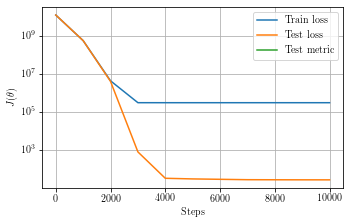

In [21]:
loss_train = np.sum(
    np.array(losshistory.loss_train) * losshistory.loss_weights, axis=1
)
loss_test = np.sum(
    np.array(losshistory.loss_test) * losshistory.loss_weights, axis=1
)

fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
ax.semilogy(losshistory.steps, loss_train, label="Train loss")
ax.semilogy(losshistory.steps, loss_test, label="Test loss")
for i in range(len(losshistory.metrics_test[0])):
    ax.semilogy(
        losshistory.steps,
        np.array(losshistory.metrics_test)[:, i],
        label="Test metric",
    )
ax.set_xlabel('Steps')
ax.set_ylabel(r'$J(\theta)$')
plt.grid()
plt.legend(loc='best')

fig.savefig('{}.pdf'.format('figs/loss'), bbox_inches='tight')
plt.show()

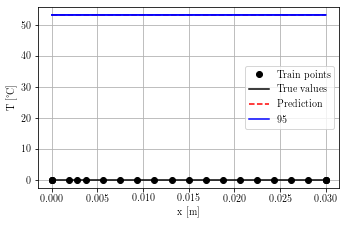

In [22]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()
y_dim = y_train.shape[1]
idx = np.argsort(X_test[:, 0])
X = X_test[idx, 0]

# regression plot
fig = plt.figure(figsize=figsize(1))
ax = fig.add_subplot(111)
for i in range(y_dim):
    ax.plot(X_train[:, 0], y_train[:, i], 'ok', label='Train points')
    ax.plot(X, y_test[idx, i], "-k", label='True values')
    ax.plot(X, best_y[idx, i], "--r", label='Prediction')
    if best_ystd is not None:
        ax.plot(X, best_y[idx, i] + 2 * best_ystd[idx, i], '-b', label='95% confidence interval')
        ax.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], '-b')
ax.set_xlabel('x [m]')
ax.set_ylabel('T [°C]')
plt.grid()
plt.legend(loc='best')

fig.savefig('{}.pdf'.format('figs/regression'), bbox_inches='tight')
plt.show()